In [395]:
!pip3 install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [517]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pywt
import scipy.stats
from google.colab import drive
import pandas as pd
import umap.umap_ as umap
from torchaudio.transforms import LFCC
import IPython
import torch
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [434]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML lab 04/bird_songs_metadata.csv")

In [435]:
# not "Richard E. Webster", because there are too few occurences of one of the species
data = data[data.recordist == "Paul Marvin"]
data.recordist.describe()

count             475
unique              1
top       Paul Marvin
freq              475
Name: recordist, dtype: object

In [436]:
print(data.species.unique())
for name in data.species.unique():
  print(len(data[data.species == name]))

['bewickii' 'polyglottos' 'migratorius' 'melodia' 'cardinalis']
170
97
89
21
98


In [437]:
data = data.groupby('species').head(21).reset_index()
data

,index,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,33,486798,Thryomanes,bewickii,NaN,Bewick's Wren,Paul Marvin,United States,"Monument Rd and nearby trails, Tijuana River V...",32.5458,-117.0737,10,song,//www.xeno-canto.org/486798,//creativecommons.org/licenses/by-nc-sa/4.0/,08:34,2019-07-11,NaN,486798-0.wav
1,34,486798,Thryomanes,bewickii,NaN,Bewick's Wren,Paul Marvin,United States,"Monument Rd and nearby trails, Tijuana River V...",32.5458,-117.0737,10,song,//www.xeno-canto.org/486798,//creativecommons.org/licenses/by-nc-sa/4.0/,08:34,2019-07-11,NaN,486798-1.wav
2,35,486798,Thryomanes,bewickii,NaN,Bewick's Wren,Paul Marvin,United States,"Monument Rd and nearby trails, Tijuana River V...",32.5458,-117.0737,10,song,//www.xeno-canto.org/486798,//creativecommons.org/licenses/by-nc-sa/4.0/,08:34,2019-07-11,NaN,486798-3.wav
3,36,486798,Thryomanes,bewickii,NaN,Bewick's Wren,Paul Marvin,United States,"Monument Rd and nearby trails, Tijuana River V...",32.5458,-117.0737,10,song,//www.xeno-canto.org/486798,//creativecommons.org/licenses/by-nc-sa/4.0/,08:34,2019-07-11,NaN,486798-4.wav
4,37,486798,Thryomanes,bewickii,NaN,Bewick's Wren,Paul Marvin,United States,"Monument Rd and nearby trails, Tijuana River V...",32.5458,-117.0737,10,song,//www.xeno-canto.org/486798,//creativecommons.org/licenses/by-nc-sa/4.0/,08:34,2019-07-11,NaN,486798-6.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,4631,460604,Cardinalis,cardinalis,NaN,Northern Cardinal,Paul Marvin,United States,"Lost Maples State Natural Area, Texas",29.8235,-99.5773,700,song,//www.xeno-canto.org/460604,//creativecommons.org/licenses/by-nc-sa/4.0/,11:56,2012-04-09,NaN,460604-7.wav
101,4632,460604,Cardinalis,cardinalis,NaN,Northern Cardinal,Paul Marvin,United States,"Lost Maples State Natural Area, Texas",29.8235,-99.5773,700,song,//www.xeno-canto.org/460604,//creativecommons.org/licenses/by-nc-sa/4.0/,11:56,2012-04-09,NaN,460604-8.wav
102,4633,460604,Cardinalis,cardinalis,NaN,Northern Cardinal,Paul Marvin,United States,"Lost Maples State Natural Area, Texas",29.8235,-99.5773,700,song,//www.xeno-canto.org/460604,//creativecommons.org/licenses/by-nc-sa/4.0/,11:56,2012-04-09,NaN,460604-9.wav
103,4634,460604,Cardinalis,cardinalis,NaN,Northern Cardinal,Paul Marvin,United States,"Lost Maples State Natural Area, Texas",29.8235,-99.5773,700,song,//www.xeno-canto.org/460604,//creativecommons.org/licenses/by-nc-sa/4.0/,11:56,2012-04-09,NaN,460604-10.wav


In [438]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/ML lab 04/wavfiles/'

In [476]:
# https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

def get_features(values):
    _,counts = np.unique(values, return_counts=True)
    entropy=scipy.stats.entropy(counts/ len(values))
    
    q5 = np.percentile(values, 5)
    q25 = np.percentile(values, 25)
    q75 = np.percentile(values, 75)
    q95 = np.percentile(values, 95)
    median = np.percentile(values, 50)
    mean = np.mean(values)
    std = np.std(values)
    var = np.var(values)

    tr = np.sqrt(2*np.log2(len(values)))  # Compute Threshold
    rms = np.mean(np.sqrt(values**2))


    return [entropy, q5, q25, q75, q95, median, mean, std, var, tr, rms, ((values[:-1] * values[1:]) < 0).sum(), (((values[:-1] - mean) * (values[1:] - mean)) < 0).sum()]

In [477]:
FILE_LENGTH = 66150
print(66150)

for i, audio_f in enumerate(data.filename):
  audio_file, sr = librosa.load(DATA_DIR + audio_f)
  if FILE_LENGTH != len(audio_file):
    print('ALARM')

66150


In [ ]:
transform = LFCC()
stats = []
mels = []

for file in data.filename:
    wave, _ = librosa.load(DATA_DIR +file)

    features = []
    for value in pywt.wavedec(wave, 'db1'):
        features += get_features(value)
    
    stats.append(features)
    mels.append(transform(torch.Tensor(wave)).mean(dim=1))

In [479]:
my_embeddings = umap.UMAP().fit_transform(stats)
lfcc_embeddings = umap.UMAP().fit_transform(torch.stack(mels))

In [480]:
species_colors = {'bewickii' : 'gold', 'polyglottos' : 'lime', 'migratorius': 'black', 'melodia': 'darkviolet',  'cardinalis': 'crimson'}
colors = [species_colors[bird] for bird in data.species.values]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in species_colors.values()]

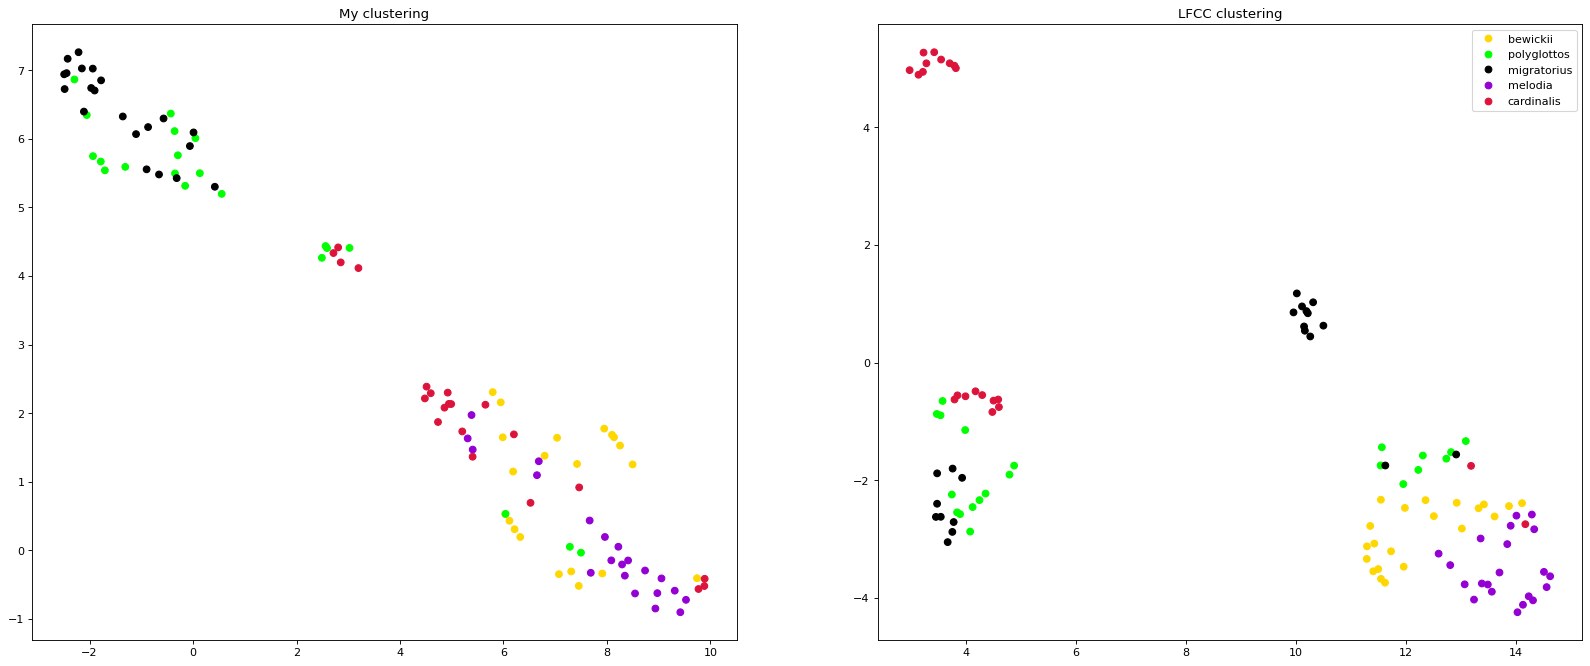

In [481]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), dpi=80)
ax1.title.set_text('My clustering')
ax2.title.set_text('LFCC clustering')

ax2.legend(markers, species_colors.keys(), numpoints=1)


ax1.scatter(my_embeddings[:, 0], my_embeddings[:, 1], c=colors)
ax2.scatter(lfcc_embeddings[:, 0], lfcc_embeddings[:, 1], c=colors)

In [488]:
data[data.species == 'migratorius'].id

42    537326
43    537326
44    537326
45    537326
46    537326
47    537326
48    537326
49    537326
50    537326
51    537326
52    537326
53    537326
54    294460
55    294460
56    294460
57    294460
58    294460
59    294460
60    294460
61    294460
62    294460
Name: id, dtype: int64

In [489]:
data[data.species == 'polyglottos'].id

21    545900
22    545900
23    545900
24    545900
25    545900
26    545900
27    545900
28    545900
29    545900
30    545900
31    545900
32    545900
33    545900
34    538537
35    538537
36    538537
37    538537
38    538537
39    538537
40    538537
41    538537
Name: id, dtype: int64

In [511]:
print(''.join(str(i) if my_embeddings[i, 0] == np.min(my_embeddings[42:63, 0]) else '' for i in range(len(my_embeddings))))

51


In [512]:
print(''.join(str(i) if my_embeddings[i, 0] == np.min(my_embeddings[21:42, 0]) else '' for i in range(len(my_embeddings))))

23


In [515]:
data.filename[51]

'537326-9.wav'

In [518]:
IPython.display.Audio(DATA_DIR + data.filename[51])

In [519]:
IPython.display.Audio(DATA_DIR + data.filename[23])